In [1]:
import ipython_microblaze as ipmb
from pynq.overlays.base import BaseOverlay
base = BaseOverlay('base.bit')

# KEYPAD CODE + SPI TRANSFER FUNCTION (C Code)

In [2]:
%%microblaze_functions base.ARDUINO
#include <pyprintf.h>
#include <arduino.h>
#include "xgpio_l.h"
#include "xgpio.h"

// select IO locations for button scan
#define IO0 (1<<0)
#define IO1 (1<<1)
#define IO2 (1<<2)
#define IO3 (1<<3)
#define IO4 (1<<4)
#define IO5 (1<<5)
#define IO6 (1<<6)
#define IO7 (1<<7)
#define IO8 (1<<8)
#define IO9 (1<<9)
#define IO10 (1<<10)

// gpio variable
XGpio gpo;

// 2d matrix button scan decode
// the second number is the row, first is a column
static u8 buttonLookup[4][4] = {
    {15,11,7,3},
    {14,10,6,2},
    {13,9,5,1},
    {12,8,4,0}
};

void setup_keypad(void) {
        
    //initialize arduino MB    
    arduino_init(0,1,0,0);

    //config switch    
    config_arduino_switch(A_GPIO, A_GPIO, A_GPIO, A_GPIO, A_GPIO, A_GPIO,
                               D_GPIO, D_GPIO, D_GPIO, D_GPIO, D_GPIO,
                               D_GPIO, D_GPIO, D_GPIO, D_GPIO,
                               D_SS, D_MOSI, D_MISO, D_SPICLK);

    // setup GPIO port for button scan, C columns read, R rows write
    XGpio_Initialize(&gpo, XPAR_GPIO_0_DEVICE_ID);
    XGpio_SetDataDirection(&gpo, 1, 0xFF0F);  // columns are lower in the byte
}//setup_keypad()

    //these are the current key colors
    static u8 i=0,j=0,k=0,l=0,n=0,o=0,p=0,q=0,r=0,s=0,t=0,u=0,v=0,w=0,x=0,y=0;

//note to self
//byte rowPins[ROWS] = {6,7,8,9}; //connect to the row pinouts of the keypad
//byte colPins[COLS] = {3,4,5,11}; //connect to the column pinouts of the keypad

//For encoders/display/buttoncolors
static void _spi_transfer(u32 BaseAddress, int bytecount,
                  u8* readBuffer, u8* writeBuffer) {
    int i;
    XSpi_WriteReg(BaseAddress,XSP_SSR_OFFSET, 0xfe);
    for (i=0; i<bytecount; i++){
        //pyprintf("In Write: %d\n", i);
        if (writeBuffer) {
            XSpi_WriteReg(BaseAddress,XSP_DTR_OFFSET, writeBuffer[i]);
        } else {
            XSpi_WriteReg(BaseAddress,XSP_DTR_OFFSET, 0);
        }
    }
    //while(((XSpi_ReadReg(BaseAddress,XSP_SR_OFFSET) & 0x04)) != 0x04);
        //for(volatile int i = 0; i < 10; ++i);// Add this
         while(((XSpi_ReadReg(BaseAddress,XSP_SR_OFFSET) & 0x05)) != 0x04);
    
    // Read SPI
    for(i=0;i< bytecount; i++){
        if (readBuffer) {
           readBuffer[i] = XSpi_ReadReg(BaseAddress,XSP_DRR_OFFSET);
        } else {
            XSpi_ReadReg(BaseAddress,XSP_DRR_OFFSET);
        }
    }

    XSpi_WriteReg(BaseAddress, XSP_SSR_OFFSET, 0xff);
}

// send the color word to the keypad
int keycolor16(int keynum, int colornum )
{
    u8 tempo[8]; 
    u8 scratch[8]; 

    int go=0;
    //this is the secret decoder ring for the key colors
    u8 colormap[11]={0b0000,0b0001,0b0011,0b0111,0b0110,0b1000,0b1010,0b1110,0b1001,0b1011,0b1111};
    //off, red, org, yel, grn, dkblu, lt blu, aqua, pink, lt pink, wht

 //pick the color variable to modify basedon the key number   
    switch (keynum){          
        case 0:
            i=colornum;
            go=1;
        break;
        case 1:
            j=colornum;
            go=1;
        break;
        case 2:
            k=colornum;
            go=1;
        break;
        case 3:
            l=colornum;
            go=1;
        break;
        case 4:
            n=colornum;
            go=1;
        break;
        case 5:
            o=colornum;
            go=1;
        break;
        case 6:
            p=colornum;
            go=1;
        break;
        case 7:
            q=colornum;
            go=1;
        break;
        case 8:
            r=colornum;
            go=1;
        break;
        case 9:
            s=colornum;
            go=1;
        break;
        case 10:
            t=colornum;
            go=1;
        break;
        case 11:
            u=colornum;
            go=1;
        break;
        case 12:
            v=colornum;
            go=1;
        break;
        case 13:
            w=colornum;
            go=1;
        break;
        case 14:
            x=colornum;
            go=1;
        break;
        case 15:
            y=colornum;
            go=1;
        break;
        default:
            go=0;
            
    }
    //if the set was valid (go=1)
    if(go){
        // build color control word
        tempo[0]=(0b00001111&colormap[i]) +((0b00001111&colormap[j])<<4);  
        tempo[1]=(0b00001111&colormap[k]) +((0b00001111&colormap[l])<<4);              
        tempo[2]=(0b00001111&colormap[n]) +((0b00001111&colormap[o])<<4);           
        tempo[3]=(0b00001111&colormap[p]) +((0b00001111&colormap[q])<<4);           
        tempo[4]=(0b00001111&colormap[r]) +((0b00001111&colormap[s])<<4);            
        tempo[5]=(0b00001111&colormap[t]) +((0b00001111&colormap[u])<<4);       
        tempo[6]=(0b00001111&colormap[v]) +((0b00001111&colormap[w])<<4);      
        tempo[7]=(0b00001111&colormap[x]) +((0b00001111&colormap[y])<<4);    
    //send word
        for (int ii=0;ii<8;ii++){
            _spi_transfer(DIRECT_SPI_BASEADDR, 8, scratch, tempo);
        }          
    }
    
   return(0);
}//keycolor16()

// increment when pressing a button
// I think this initializes everything to zero
u8 buttonstate[16] = {0};

// scan the keypad
unsigned int getkey(void){
    u8 c, keynum=0;
    int i = IO7;

    for(u8 r=4; r>0;){
        r--;
        XGpio_DiscreteWrite(&gpo, 1, (~i));
        int read = XGpio_DiscreteRead(&gpo,1);
        c = 0;

        if ((read&IO0)==0) {
            c = 1;
        } else if ((read&IO1)==0) {
            c = 2;
        } else if ((read&IO2)==0) {
            c = 3;
        } else if ((read&IO3)==0) {
            c = 4;
        }
        
        // detected a valid button press, output the number
        if (c!=0) {
            c--;
            keynum = buttonLookup[c][r];
            keynum++;
            break;
        }
        i=i>>1;
    }

    return(keynum);
}//getkey()

# BITBANG SPI Code to peripherals (C Code)


Use PMODA to check encoders, PMODB outputs data onto display

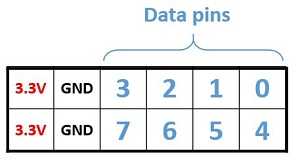

In [3]:
%%microblaze_functions base.PMODA
#include <pmod.h>
#include "xgpio.h"
#include <pyprintf.h>
#include <timer.h>
// select IO locations for button scan
#define MISOp (1<<0)
#define SCKp (1<<1)
#define MOSIp (1<<2)
#define SSp (1<<3)

#define PMOD_DIO_BASEADDR 0x40000000
XGpio gpo;


//For encoders. Data direction low is output
void setup_bitbang(void){
    
    
    //MISO,  SPICLK,MOSI,  SS
    config_pmod_switch(GPIO_0,GPIO_1,GPIO_2,GPIO_3,
                       GPIO_4,GPIO_5,GPIO_6,GPIO_7);
    pmod_init(0,0);
    
    XGpio_Initialize(&gpo,PMOD_DIO_BASEADDR);
 //setup port   
    XGpio_SetDataDirection(&gpo, 1,0x00000001);
    XGpio_DiscreteWrite(&gpo, 1, 0);    //set evryone low
  //  XGpio_DiscreteWrite(&gpo, 1, SSp);    //set SS high
}//setup_bitbang()

//Ask ARDUINO to send Encoder Data
//Need to send command 3x to ARDUINO slave to successfully transfer
int bitbangSPI(int cmd){
   int count=0,tempo=0;
   u8 dbit=0; 
    
    
    XGpio_DiscreteWrite(&gpo, 1, 0b00000001 ) ;   //set SS low
    
    //FIRST BYTE
    for(volatile int i = 0; i < 200; ++i);// delay
    for (int i = 0; i < 8; i++)
    {
        // set data bit 
        if (cmd & 1<<(7-i))
             dbit=1;    //set databit 
        else
             dbit=0;    //set databit low
        
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );
  
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );
  
        XGpio_DiscreteWrite(&gpo, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        tempo=XGpio_DiscreteRead(&gpo,1)&0b00000001; //rising edge read here
        
        XGpio_DiscreteWrite(&gpo, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );    //set clk low
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );    //set clk low
        
        if (tempo)
            count= (count | (1<<(7-i)));
        else
            count =(count & ~(1<<(7-i)));
    } 
    //SECOND BYTE
    for(volatile int i = 0; i < 400; ++i);// delay
    count=0;
    for (int i = 0; i < 8 ;i++)
    {
        // set data bit 
        if (cmd & 1<<(7-i))
             dbit=1;    //set databit 
        else
             dbit=0;    //set databit low
        
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );
  
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );
  
        XGpio_DiscreteWrite(&gpo, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        tempo=XGpio_DiscreteRead(&gpo,1)&0b00000001; //rising edge read here
        
        XGpio_DiscreteWrite(&gpo, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );    //set clk low
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );    //set clk low
        
        if (tempo)
            count= (count | (1<<(7-i)));
        else
            count =(count & ~(1<<(7-i)));
    } 
    
    int tempo_out = count;
    
    //THIRD BYTE
    for(volatile int i = 0; i < 400; ++i);// delay
    count=0;
    for (int i = 0;i < 8; i++)
    {
        // set data bit 
        if (cmd & 1<<(7-i))
             dbit=1;    //set databit 
        else
             dbit=0;    //set databit low
        
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );
  
        XGpio_DiscreteWrite(&gpo, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        tempo=XGpio_DiscreteRead(&gpo,1)&0b00000001; //rising edge read here
        
        XGpio_DiscreteWrite(&gpo, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );    //set clk low
        XGpio_DiscreteWrite(&gpo, 1, 0b00000001 | dbit<< 2 );    //set clk low

        
        if (tempo)
            count= (count | (1<<(7-i)));
        else
            count =(count & ~(1<<(7-i)));
    } 
    

    for(volatile int i = 0; i < 200; ++i);// delay    
    
    XGpio_DiscreteWrite(&gpo, 1, SSp);    //set SS high  
    
    return tempo_out;
    
}  
void mute(int duration){
    
           XGpio_DiscreteWrite(&gpo, 1, 0x000); // pulse mute low
            for(volatile int i = 0; i < duration; ++i);// Add this
           XGpio_DiscreteWrite(&gpo, 1, 0x010); // pulse mute high again    
    
}

In [4]:
%%microblaze_functions base.PMODB
//added mute pulse drive function  
#include <pmod.h>
#include "xgpio.h"
#include <pyprintf.h>
#include <timer.h>
// select IO locations for button scan
#define MISOp (1<<0)
#define SCKp (1<<1)
#define MOSIp (1<<2)
#define SSp (1<<3)

#define PMOD_DIO_BASEADDR 0x40000000
XGpio gpo_disp;

void setup_bb_display(void){
    
    //MISO,  SPICLK,MOSI,  SS
    config_pmod_switch(GPIO_0,GPIO_1,GPIO_2,GPIO_3,
                       GPIO_4,GPIO_5,GPIO_6,GPIO_7);
    pmod_init(0,0);
    
    XGpio_Initialize(&gpo_disp,PMOD_DIO_BASEADDR);
 //setup port   
    XGpio_SetDataDirection(&gpo_disp, 1,0x00000001);
    XGpio_DiscreteWrite(&gpo_disp, 1, 0);    //set evryone low
  //  XGpio_DiscreteWrite(&gpo_disp, 1, SSp);    //set SS high
 //bitbang
    
}

// create the bitbang spi command from page and instrument inputs
int bb_spi_display(int d_instrument, int d_page){
    int count=0,tempo=0;
    u8 dbit=0;
    u8 cmd = (((d_instrument&0xF)<<4)+(d_page&0xF));

    XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 ) ;   //set SS low
    for(volatile int i = 0; i < 200; ++i);// delay

    for (int i=0;i<8;i++){
        // set data bit 
        if (cmd & 1<<(7-i))
             dbit=1;    //set databit 
        else
             dbit=0;    //set databit low
        
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000011 | dbit<< 2 );    //set clk high
        tempo=XGpio_DiscreteRead(&gpo_disp,1)&0b00000001; //rising edge read here
        
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000011 | dbit<< 2 );    //set clk high
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );    //set clk low
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );    //set clk low
        
        if (tempo)
            count= (count | (1<<(7-i)));
        else
            count =(count & ~(1<<(7-i)));
        
    } //second byte
    count=0;
    for(volatile int i = 0; i < 400; ++i);// delay
    for (int i=0;i<8;i++){
        // set data bit 
        if (cmd & 1<<(7-i))
             dbit=1;    //set databit 
        else
             dbit=0;    //set databit low
        
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000011 | dbit<< 2 );    //set clk high
            
        tempo=XGpio_DiscreteRead(&gpo_disp,1)&0b00000001; //rising edge read here
        
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000011 | dbit<< 2 );    //set clk high
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );    //set clk low
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );    //set clk low
        
        if (tempo)
            count= (count | (1<<(7-i)));
        else
            count =(count & ~(1<<(7-i)));
        
    } 
    
        int tempo_out=count;
    
    //third byte
    count=0;
    for(volatile int i = 0; i < 400; ++i);// delay
    for (int i=0;i<8;i++){
        // set data bit 
        if (cmd & 1<<(7-i))
             dbit=1;    //set databit 
        else
             dbit=0;    //set databit low
        
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000011 | dbit<< 2 );    //set clk high
        tempo=XGpio_DiscreteRead(&gpo_disp,1)&0b00000001; //rising edge read here
        
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000011 | dbit<< 2 );    //set clk high
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );    //set clk low
        XGpio_DiscreteWrite(&gpo_disp, 1, 0b00000001 | dbit<< 2 );    //set clk low
        
        if (tempo)
            count= (count | (1<<(7-i)));
        else
            count =(count & ~(1<<(7-i)));

    } 

    for(volatile int i = 0; i < 200; ++i);// delay    
    XGpio_DiscreteWrite(&gpo_disp, 1, SSp);    //set SS high      
    return tempo_out;
    
}  

# Init Encoder/Page/Instrument Logic (Python Code)

In [5]:
# PYTHON FUNCTIONS, INITIALIZATION, PREPARATION
import time
import pickle
from pynq.lib import Button
from pynq.overlays.base import BaseOverlay
pAudio = base.audio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

#like preprocessor defines in C
MAXPAGE = 4
MAXINSTRUMENT = 5
MAXBUTTON = 16

#some useful variables
keyin = 0
enc_page = 0
read_page = 0
btn_page = 1
page = 1
enc_instr = 0
read_instr = 0
btn_instr = 1
instrument = 1

#prepare the arduino IO and Encoder spi bitbang as above
setup_keypad()

for i in range(0,16):
    keycolor16(i, 8 )
    
setup_bitbang()
setup_bb_display()

for i in range(0,16):
    keycolor16(i, 8 )
        
# load up the sound files -- future select the files that are in use
combo_array = ["null","5","4","45","3","35","34","345","2","25","24","245","23","235","234","2345",
            "1","15","14","145","13","135","134","1345","12","125","124","1245","123","1235","1234","12345"]

swap_LUT = [0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30, 
            1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31 ]
#Sound 4 and 5 (Cminor and Abmajor) should never be played concurrently; manually fix that
for i in range(len(combo_array)):
    if "45" in combo_array[i]:
        combo_array[i] = combo_array[i-1]
##
npy=np.squeeze(np.load('1.npy'))

#translate the Pynq RGB LED numbers into cool buttons RgGB numbers
led_lookup = [0,5,4,7,1,8,0,0,0,10]
rgbled_position = [4,5]

#32 element list of the settings state
sequence = [0 for i in range(MAXBUTTON*MAXPAGE)]

# retrieves a saved sequence
import pickle
try:
    with open("sequencer.txt", "rb") as fp:   # Unpickling
           sequence = pickle.load(fp)
except:
    print("using new sequence")
    
# read in the encoder information
#Instrument Selector Encoder
read_instr = (bitbangSPI(1)%MAXINSTRUMENT)
enc_instr = read_instr
instrument = ((btn_instr + read_instr)%MAXINSTRUMENT)+1

#Page Selector Encoder
read_page = (bitbangSPI(2)%MAXPAGE)
enc_page = read_page
page = ((btn_page + read_page)%MAXPAGE)+1

#the instrument button only increments it, cycles back to one
def instrumentadd(i):
    i += 1
    if i > MAXINSTRUMENT:
        i = 1
    time.sleep(0.2)
    return i;

#select next page, buttons ascend to the left
def pageleft(p):
    if p < (MAXPAGE):
        p+=1
    else:
        p=1
    time.sleep(0.2)
    return p;

#select previous page, buttons descend to the right
def pageright(p):
    if p > 1:
        p-=1
    else:
        p=(MAXPAGE)
    time.sleep(0.2)
    return p;

def setpageleds(p):
    for led in base.leds:
        led.off()
    base.leds.write((1<<(p-1)),1)
    return;

#display the current page/instrument LEDs, used on most updates
def coolleds(instrument, page):
    bb_spi_display(instrument,page)
    for i in range(16):
        input = sequence[16*(page-1)+i]
        select = 1<<(instrument-1)
        if (input & select) != 0:
            keycolor16(i,led_lookup[instrument])
        else:
            keycolor16(i,0)

# dictionary lookup for led_keys in run mode
def decode(x):
    return {
        1: 1,
        2: 2,
        4: 3,
        8: 4,
        16: 5
    }.get(x,9)

# display all the instruments on run mode page
def showleds(page):
    for i in range(16):
        input = sequence[16*page+i]
        if input != 0:
            output = led_lookup[decode(input)]
        else:
            output = 0
        keycolor16(i,output)
        
        

using new sequence


# UI Loop (Python Code)

In [ ]:
#updated for no play on zero beat steps 11feb18 JK DP
import time
import pickle
from pynq.lib import Button
from pynq.overlays.base import BaseOverlay
pAudio = base.audio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

PGM=4
RUN=2
RUNWORD=15
PGMWORD=14

#initialize indicator states
for led in rgbled_position:
    base.rgbleds[led].write(instrument)
    setpageleds(page)
    
coolleds(instrument, page)



NUM_WAVS = 2**MAXINSTRUMENT

tSound = np.zeros((npy.size,NUM_WAVS))
nosound=np.random.randint(32,size=(npy.size,1))

tSound[:,0] = np.squeeze(nosound)
    
for i in range(1,NUM_WAVS):
    #Load npy array based on combo_array filenames (leave slot zero empty)
    tSound[:,i] = np.squeeze(np.load(combo_array[swap_LUT[i]] + ".npy"))

sound_idx_dictionary = [1, 2, 4, 8, 16]

def playInstr(instrument):
    #Instrument array might need to be flipped
    idx = instrument-1 #2**(instrument-1)+1
    pAudio.buffer=tSound[:,sound_idx_dictionary[idx]].copy(order='C')
    pAudio.play()
    
while(1):
    bb_spi_display(PGMWORD,page)  
    coolleds(instrument, page)
    #### START UI/PGM MODE
    while (base.buttons[3].read()==0):
        time.sleep(0.1)
        base.rgbleds[5].write(PGM)
        ###ENCODER CHECKS
        #Keep Selected Instrument Updated (Encoders)
        read_instr = (bitbangSPI(1)%MAXINSTRUMENT)
        if (read_instr != enc_instr):
            enc_instr = read_instr
            instrument = ((btn_instr + read_instr)%MAXINSTRUMENT) + 1
            playInstr(instrument)
            coolleds(instrument, page)
            #for led in rgbled_position:
            base.rgbleds[4].write(instrument) # bits are 0bRGB, blue is lsb
                
        #Keep Selected Page Updated (Encoders)
        read_page = (bitbangSPI(2)%MAXPAGE)
        if(read_page != enc_page):
            enc_page = read_page
            page = ((btn_page + read_page)%MAXPAGE)+1
            coolleds(instrument, page)
            setpageleds(page)
        ###ENCODER CHECKS
        
        ###BUTTON CHECKS
        #Keep Selected Instrument Updated (Buttons)
        if (base.buttons[2].read()==1):
            btn_instr = instrumentadd(btn_instr)
            instrument = ((btn_instr + read_instr)%MAXINSTRUMENT)+1
            playInstr(instrument)
            coolleds(instrument, page)
            #for led in rgbled_position:
            base.rgbleds[4].write(instrument)
        #Cycle Page Left (Buttons)
        elif (base.buttons[1].read()==1):
            btn_page = pageleft(btn_page)
            page = ((btn_page + read_page)%MAXPAGE)+1
            setpageleds(page)
            coolleds(instrument, page)
        #Cycle Page Right (Buttons)
        elif (base.buttons[0].read()==1):
            btn_page = pageright(btn_page)
            page = ((btn_page + read_page)%MAXPAGE)+1
            setpageleds(page)
            coolleds(instrument, page)
        #Check MIDI Button Press
        if keyin is 0:
            keyin = getkey()
        else:
            #Figure out which button was pressed
            select = 1<<(instrument-1)
            sequence[16*(page-1)+keyin-1] ^= select
            keyin = 0;
            coolleds(instrument, page)
            #playInstr(instrument)            
        ###BUTTON CHECKS  
    #### END UI/PGM MODE

    #Run Loop Index
    ii = 0
    bb_spi_display(RUNWORD,int(ii/16)+1)
    #Most recent button index
    last = 0
    
    # sleep between modes because they use the same button
    time.sleep(0.2)
    
    # run mode
    while(base.buttons[3].read()==0):
        base.rgbleds[5].write(RUN) # change to green for run mode
        base.rgbleds[4].off() #turn off instrument select
        #cc = tSound[:,sequence[ii]].copy(order='C')
        keycolor16(last, 0 )
        last = ii%16    
        keycolor16(last, 10 )
        if last == 0:
            bb_spi_display(RUNWORD,int(ii/16)+1)
            showleds(int(ii/16))
        if sequence[ii] !=0:
            pAudio.buffer=tSound[:,sequence[ii]].copy(order='C')
            mute(10000) # drives the mute pulse, PMODA, pin4 
            pAudio.play()
        else:
            time.sleep(0.250)
            
        ii=ii+1
        if ii>len(sequence)-1:
            ii=0
            
    # delay debounce when returning to program mode
    time.sleep(0.2)

In [9]:
import pickle
with open("sequencer1SH.txt", "wb") as fp:   #Pickling
       pickle.dump(sequence, fp)

In [ ]:
import pickle
with open("sequencer.txt", "rb") as fp:   # Unpickling
       sequence = pickle.load(fp)